### Installation des dépendances

In [25]:
%pip install numpy
%pip install opencv-python
%pip install -U matplotlib
%pip install einops
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
import os
import time
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from einops import rearrange
from PIL import Image # Using here to convert openCV image to PIL image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [26]:
# Define Constants
STEP_TO_NEXT_FRAME = 4 
""" in each video, we will read 1 frame every 24/STEP_TO_INDEX frames"""
DEBUG = False # if True, print debug information
NUMBER_OF_VIDEO = 100 # number of videos to index
MAX_FRAME_INDEXATION_TIME = 3 # in seconds
MAX_SEARCH_TIME = 0.1 # in seconds
VIDEOS_SIZE_ON_DISK = 444039168  # in octets
MAX_FRAME_NUMBER = 37895 # maximum number of frames in all video
N = int(MAX_FRAME_NUMBER/STEP_TO_NEXT_FRAME) # index Length
D = 128 # index Depth

In [27]:
#Define all global variables
imageList = []
videoList = []
frameIndexationTime = [] # Time must be in seconds
imageSearchTime = [] # Time must be in seconds
imageCompressionRateList = []
videoCompressionRateList = []
indexationTable = [] # Table of indexation
Descriptor_list = np.empty((N, D * 3), dtype=np.float32) # Descriptor of the image
resnet_descriptor = np.empty((N, 512), dtype=np.float32) # Descriptor of the image by resnet

### Lecture des fichiers

In [28]:
imagePath = "/data/jpeg/"
videoPath = "/data/mp4/"
currDirectory = os.getcwd()
imageList = os.listdir(currDirectory + imagePath)
videoList = os.listdir(currDirectory + videoPath)
# for file in imageList:
#     filePath = currDirectory + dataPath + file
#     img = cv.imread(filePath, cv.IMREAD_COLOR)

In [29]:
def getVideoParameter(videoPath:str):
    """return the frame rate and the number of frames of the video."""
    cap = cv2.VideoCapture(videoPath)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    return fps, frame_count
    

In [30]:
def cv2_to_pil(cv2_img):
    """Convert openCV image to PIL image to perfom resnet computing"""
    cv2_im_rgb = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(cv2_im_rgb)
    return pil_img

In [31]:
# Resnet-18 model loading
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)   # le modèle est chargé avec des poids pré-entrainés sur ImageNet
model = torch.nn.Sequential(*(list(model.children())[:-1]))        # supprime la dernière couche du réseau
model.eval()
if torch.cuda.is_available():  
    model.cuda() # On envoie le modèle sur le GPU

In [32]:
def ImageVectorResnet_CPU(imagePath, needToRead:bool = True):
    """Return resnet18 image descriptor"""
    if needToRead:
        image = cv2.imread(imagePath)
    else:
        image = imagePath
    
    new_image = cv2_to_pil(image)
    
    # Pre-processing
    preprocess = transforms.Compose([
    transforms.Resize((224, 224)),                       
        transforms.ToTensor(),                            
        transforms.Normalize(mean=[0.485, 0.456, 0.406],    
                         std=[0.229, 0.224, 0.225]),
    ])
    
    input_tensor = preprocess(new_image)         # 3 x 224 x 224
    input_batch = input_tensor.unsqueeze(0)  # Ajout d'une dimension de batch : 1 x 3 x 224 x 224
    
    if torch.cuda.is_available():  
        input_batch = input_batch.cuda() # On envoie le batch sur le GPU
    
    # Computing descriptor
    with torch.no_grad():
        output = model(input_batch)  # 1 x 512 x 1 x 1 


    output = rearrange(output, 'b d h w -> (b d h w)')  # 512
    output2_list = output.tolist()
    return output2_list

In [33]:
def plotingResnetDescriptor(descriptor:list, index_desc:int = 0):
    plt.plot(descriptor[index_desc])
    plt.title("Resnet descriptor")
    plt.show()

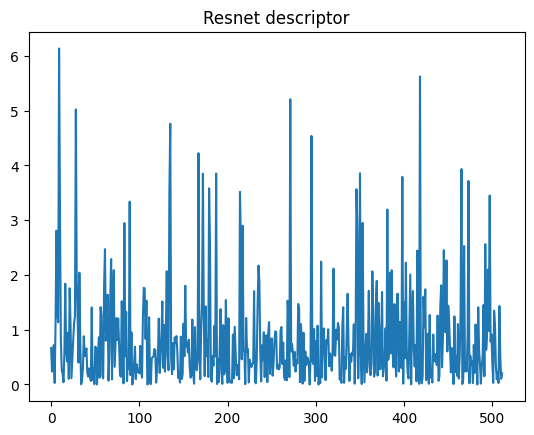

In [34]:
def createIndexTableResnet():
    """Index a video by creating a list of frames and their corresponding index. and update the indexationTable variable."""
    for video in videoList:
        path = currDirectory + videoPath + video
        fps, frame_count= getVideoParameter(path)
        cap = cv2.VideoCapture(path)
        startIndex = len(indexationTable)
        stopIndex = startIndex - 1 + math.floor(frame_count/STEP_TO_NEXT_FRAME)
        for i in range(startIndex, stopIndex):
            frameNumber = STEP_TO_NEXT_FRAME*(i-startIndex)
            indexationTable.append((frameNumber, video, (frameNumber/fps)))
            currImage = cap.set(cv2.CAP_PROP_POS_FRAMES, frameNumber)
            ret, currImage = cap.read()
            resnet_descriptor[i] = ImageVectorResnet_CPU(currImage, False)
            
 
createIndexTableResnet()       
plotingResnetDescriptor(resnet_descriptor, 1)

In [35]:
def CalculateCompressionRate():
    print(len(indexationTable))
    print(Descriptor_list.shape)
    rate = 1- (3*D*N*4)/VIDEOS_SIZE_ON_DISK #*4 because we use float32 and 3 because we have 3 channels RGB
    print(rate)
    
CalculateCompressionRate()

9338
(9473, 384)
0.9672314312596856


In [36]:
def searchImage(distanceType):
    SearchResult = []
    bestIndex = 0
    for image in imageList:
        path = currDirectory + imagePath + image
        imageVector = ImageVectorResnet_CPU(path)
        for i in range(len(indexationTable)):
            # calculer la norme de la différence entre l'image et la liste de descripteurs
            dist = np.linalg.norm(imageVector - resnet_descriptor[i])
            if i == 0:
                bestDistance = dist
                bestIndex = i
            if dist < bestDistance:
                bestDistance = dist
                bestIndex = i
        # else:
        #     # print(image.split(".")[0])
        #     # print(foundVideo_r, time_r)
        #     # print(foundVideo_g, time_g)
        #     # print(foundVideo_b, time_b)
        #     bestVideo = "out"
        #     bestTime = ""
        
        bestVideo = indexationTable[bestIndex][1]
        bestTime = indexationTable[bestIndex][2]
            
        # print("The best match is the frame number ", (image.split(".")[0], bestVideo.split(".")[0], bestTime)) 
        if type(bestTime) == float: 
            SearchResult.append((image.split(".")[0], bestVideo.split(".")[0], round(bestTime, 3)))
        else:
            SearchResult.append((image.split(".")[0], bestVideo.split(".")[0], bestTime)) 
        # break
        print("the best distance is ", bestDistance)
    return SearchResult

SearchResult = searchImage(0)
print(SearchResult)

the best distance is  5.201359125484944
the best distance is  4.1856123350717045
the best distance is  17.715132001169497
the best distance is  10.66227729038237
the best distance is  3.3430437980424377
the best distance is  12.473292317070579
the best distance is  5.855583747424209
the best distance is  12.778454534569125
the best distance is  15.6410115250882
the best distance is  7.242320018205067
the best distance is  4.949619266784796
the best distance is  5.62905577978593
the best distance is  9.667615843484336
the best distance is  6.922634333411464
the best distance is  14.702322667952913
the best distance is  14.100483218068549
the best distance is  4.763215039796703
the best distance is  5.649757979791193
the best distance is  13.804075510567285
the best distance is  15.933231970022492
the best distance is  4.663363285700792
the best distance is  13.341721984316775
the best distance is  16.274599114006303
the best distance is  6.827154093492658
the best distance is  5.4059867

In [37]:
def writeResultInCSVFile():
    """Function to write the results in a csv file."""
    with open(currDirectory+'/src/test.csv', 'w') as file:
        file.write("image,video_pred,minutage_pred\n")
        for imageName, video, time in SearchResult:
            file.write(imageName + "," + video + "," + str(time) + "\n")
    file.close()

writeResultInCSVFile()

In [38]:
# Affichage des résultats
import subprocess
directory = r'C:\Users\loicn\OneDrive - polymtl.ca\Polymtl\Session_5\INF8770_TEC_MULTIMEDIA\Lab\Lab3\src'
output = subprocess.run(['python3', 'evaluate.py', '--file', 'test.csv', '--file_gt', 'gt.csv'], cwd=directory, capture_output=True, text=True)

print(output.stdout)

Taux de bonnes rÃ©ponses : 79.5% (795/1000)
Ecart temporel moyen : 0.80 sec

